# Metropolis Hastings

## Part A: MH Proposals and Acceptance Probabilities

> *Starting with a very general notation...*

Accepting draws from a ***proposal distribution*** 

$\tilde x^{(t)} \sim q(\tilde x^{(t)}|x^{(t-1)})$

according to a "coin flip"

$x^{(t)} = \left\{\begin{array}{ll}
\tilde x^{(t)} & \text{with probability } \min\left(1,\frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}\frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})}\right) \quad \color{gray}{\begin{array}{c}\textrm{... is the normalizing constant needed for $p$?}\\\textrm{... and what happens if $q$ is symmetric?}  \end{array}}\\
x^{(t-1)} & \text{otherwise}
\end{array}\right.$

will produce draws from $p(x^{(t)})$.

### This is a two step conditional process<br>which altogether defines a <u>transition distribution</u>

$
\begin{align*}
&\quad\, \Pr(\textrm{accept}|\textrm{proposal},\textrm{current state}) q(\textrm{proposal}|\textrm{current state})\\ 
&={}
\Pr(\textrm{accept}|\textrm{proposal}) p(\textrm{proposal}|\textrm{current state})\\
&={} \Pr(x^{(t)} = \tilde x^{(t)}) q(\tilde x^{(t)}|x^{(t-1)}) = p(\tilde x^{(t)}|x^{(t-1)})
\end{align*}
$

so $q(\tilde x^{(t)}|x^{(t-1)})$ is our **proposal distribuiton** but $p(\tilde x^{(t)}|x^{(t-1)})$ is our actual **transition distribuiton**

### Does it work?

Let's see for 

$
\begin{align*}
p(x^{(t)}) & \rightarrow {} N(0,1)\\
q(\tilde x^{(t)}|x^{(t-1)}) & \rightarrow {} N(x^{(t-1)},\sigma)
\end{align*}
$


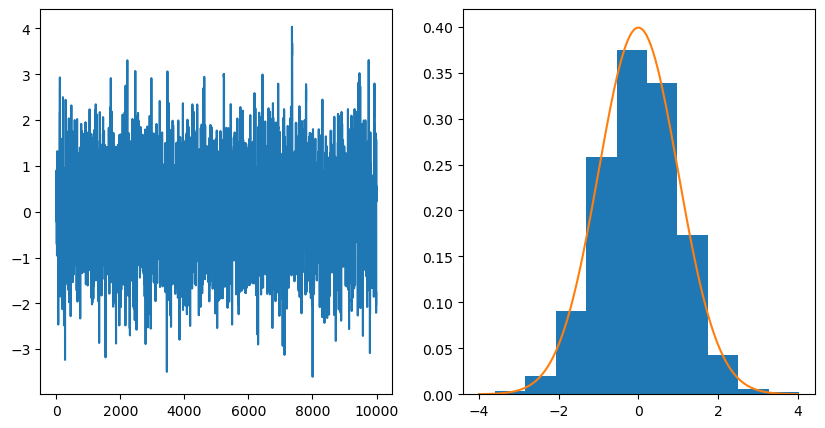

In [6]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

p_x_pdf = lambda x: stats.norm().pdf(x)
mh_tuning_parameter = 1.5
q_xt_given_xtm1 = lambda x: stats.norm(x, scale=mh_tuning_parameter)
proposal_distribution = q_xt_given_xtm1

m = 10000
x = np.zeros(m)
rejections = 0
for t in range(1,m):
    x_tilde = proposal_distribution(x[t-1]).rvs()
    acceptance_probability = min(1, p_x_pdf(x_tilde)/p_x_pdf(x[t-1]))
    if stats.uniform().rvs() < acceptance_probability:
        x[t] = x_tilde
    else:
        x[t] = x[t-1]
        rejections += 1

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(x)
ax[1].hist(x, density=True)
x_support = np.linspace(-4,4,301)
ax[1].plot(x_support, p_x_pdf(x_support));

## Part B: What is MH?


### Why doesn't this work?


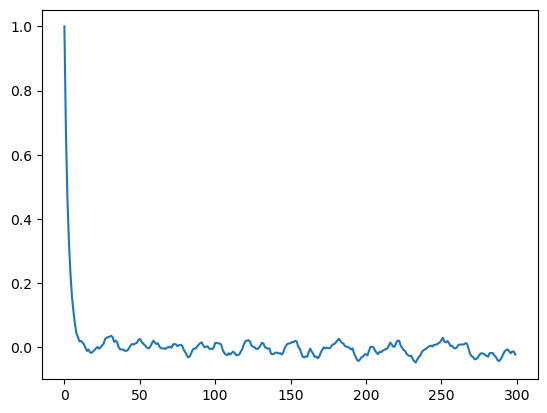

In [7]:
K = 300
autocorrelations = np.ones(K)
for t_plus_k in range(1, K):
    autocorrelations[t_plus_k] = np.corrcoef(x[:-t_plus_k], x[t_plus_k:])[0,1]
    
plt.plot(autocorrelations);

### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$

which is based on the relative value of $m$ between
- $\textrm{Var}\left(\frac{1}{n}{\sum_{t=1}^n x^{(t)}}\right) = \frac{\sigma^2}{n}$ under i.i.d. sampling and the actual 
- $\begin{align}\textrm{Var}\left(\frac{1}{m}\sum_{t=1}^m x^{(t)}\right) &={} \frac{1}{m^2}\left(\sum_{t=1}^m \textrm{Var}\left(x^{(t)}\right) + \sum_{t \neq t'} \textrm{Cov}(x^{(t)},x^{(t')})\right)\\ &={} \frac{1}{m^2}\left(m \sigma^2 + \sum_{t \neq t'} \sigma^2 \rho_{t,t'}\right)\\ &\approx{} \frac{1}{m^2}\left(m \sigma^2+2m \sigma^2 \sum_{k=1}^m\rho_k\right) \approx \frac{\sigma^2}{m}\left(1+2  \sum_{k=1}^\infty\rho_k\right) \end{align}$
- Now call $n\rightarrow n_{\textrm{eff}}$ and solve for $n_{\textrm{eff}}$ in $\frac{\sigma^2}{n_{\textrm{eff}}} = \frac{\sigma^2}{m}\left(1+2  \sum_{k=1}^\infty\rho_k\right)$ which gives our result showing what our dependent samples would have counted for relative to an i.i.d. sample size count


In [8]:
# n_eff s2 = m s2 + 2ms2 Sum r
# n_eff = m + 2m  Sum r

# m*m/n_eff = m/(1+ 2  Sum r)



In [9]:
m / (1 + 2*autocorrelations[1:100].sum())

1676.8894074775524

(14, 1859.6981103824428)

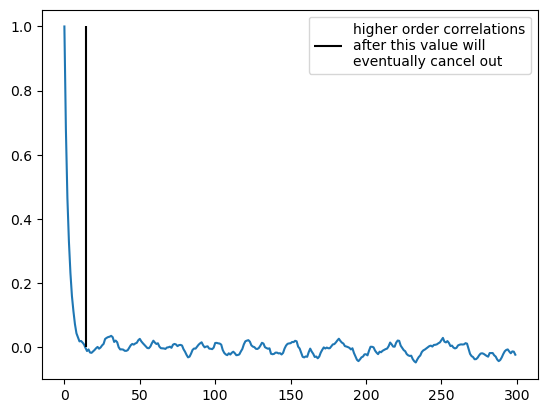

In [10]:
K = 300
autocorrelations = np.ones(K)
for t_plus_k in range(1, K):
    autocorrelations[t_plus_k] = np.corrcoef(x[:-t_plus_k], x[t_plus_k:])[0,1]

approximation_stop = (autocorrelations < 0).cumsum()
approximation_stop = approximation_stop*np.arange(K)
approximation_stop = min(approximation_stop[approximation_stop>0])

plt.plot(autocorrelations) 
plt.vlines(approximation_stop, ymin=0, ymax=1, color='k',
           label='higher order correlations\nafter this value will\neventually cancel out')
plt.legend()

# effective sample size
approximation_stop, m / (1 + 2*autocorrelations[1:approximation_stop].sum())

In [11]:
10000/14

714.2857142857143

### Rejection Rate

The **rejection rate** of the **Metropolis Hastings** algorithm given above is something else that we should keep in mind.

#### Q1: Is a high rejection rate benefiicial or detrimental for the effective sample size calculation?

#### Q2: What is the relationship between the proposal distribution and the rejection rate?

In [12]:
rejections/m

0.4131

### Why does this work?

> *Changing and hinting with the the notation to begin being suggestive about our purposes...*

If we have a **stationary distribution** $p(\theta \color{gray}{|x})$ then **transition distribution (kernel)** $p$ (not to be confused with the **Metropolis-Hastings prposal distribution** $q$!) produces a sample from this **stationary distribution** if the ***Markov chain*** it produces is ***reversible***, meaning that

$\require{cancel}
\begin{align*}
p(\theta^{(t)}|\theta^{(t-1)})p(\theta^{(t-1)}\color{gray}{|x}) & = {}  p(\theta^{(t-1)}|\theta^{(t)})p(\theta^{(t)}\color{gray}{|x})\\\\
& \textrm{But is this true if we use a Metropolis-Hastings transition distribution (kernel)?}
\\\\
p(\theta^{(t)}\color{gray}{|x}) & \overset{MH}{=} {} \frac{\alpha_{\textrm{accept prob}}^{\textrm{forward}} q(  \theta^{(t)}| \theta^{(t-1)})}{\alpha_{\textrm{accept prob}}^{\textrm{backward}} q(  \theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x})\\
p( \theta^{(t)}\color{gray}{|x}) & = {} \frac{\min\left(1,\frac{p( \theta^{(t)}\color{gray}{|x})}{p(\theta^{(t-1)}\color{gray}{|x})}\frac{q(\theta^{(t-1)}| \theta^{(t)})}{q( \theta^{(t)}|\theta^{(t-1)})}\right) q( \theta^{(t)}|\theta^{(t-1)})}{\min\left(1,\frac{p( \theta^{(t-1)}\color{gray}{|x})}{p( \theta^{(t)}\color{gray}{|x})}\frac{q( \theta^{(t)}| \theta^{(t-1)})}{q( \theta^{(t-1)}| \theta^{(t)})}\right) q(  \theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x})\\\\
& \textrm{The fractions in the "$\min$" in the numerator or denomenator are reciprocals}\\
& \textrm{thus regardless of if the numerator fraction is equal to, greater than, or less than $1$}\\\\
p( \theta^{(t)}\color{gray}{|x}) & = {} \frac{p( \theta^{(t)}\color{gray}{|x})}{p(\theta^{(t-1)}\color{gray}{|x})}\frac{q(\theta^{(t-1)}| \theta^{(t)})}{q( \theta^{(t)}|\theta^{(t-1)})} \frac{q\theta^{(t)}|\theta^{(t-1)})}{q(\theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x}) \\\\
\xcancel{p( \theta^{(t)}\color{gray}{|x})} & = {} \frac{\xcancel{p(\theta^{(t)}\color{gray}{|x})}}{\xcancel{p(\theta^{(t-1)}\color{gray}{|x})}}\frac{\cancel{q(\theta^{(t-1)}| \theta^{(t)})}}{\cancel{q( \theta^{(t)}|\theta^{(t-1)})}} \frac{\cancel{q\theta^{(t)}|\theta^{(t-1)})}}{\cancel{q(\theta^{(t-1)}|\theta^{(t)})}}\xcancel{p(\theta^{(t-1)}\color{gray}{|x})}\\  \longrightarrow \quad 1 & ={} 1 \quad \textrm{ so the equation is true and reversibility holds}
\end{align*}$

This illustrates how the entire design and purpose of the **Metropolis-Hastings** algorithm specification (which seemingly appeared magically out of thin air) is in fact based on "reverse engineering" (if you will please excuse the pun) exactly what is needed to create a **reversible Markov Chain** (whose **stationary distribution** is the **target** of the **Metropolis-Hastings** algorithm).

## Part C: Back to Gibbs sampling

**Gibbs sampling** also creates a **reversible Markov Chain** whereby the samples, forwards or backwards, are from the same **stationary distribution** (which is the **joint posterior distribution** of the (random variable) parameters of the **full conditional (posterior) distributions**


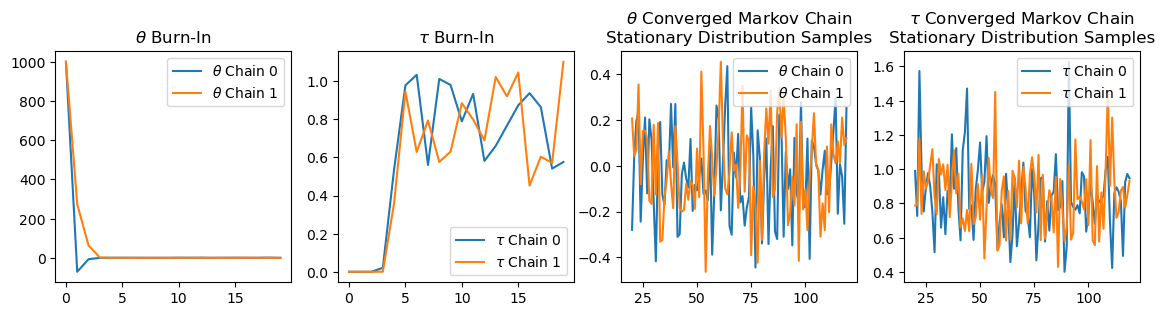

In [13]:
# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        tau[c,g] = \
        stats.gamma(a=n/2+1, 
                    scale=2/((x-theta[c,g-1])**2).sum()).rvs()
        theta[c,g] = \
        stats.norm(x.mean(), 
                   scale=1/np.sqrt(tau[c,g]*n)).rvs()

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         

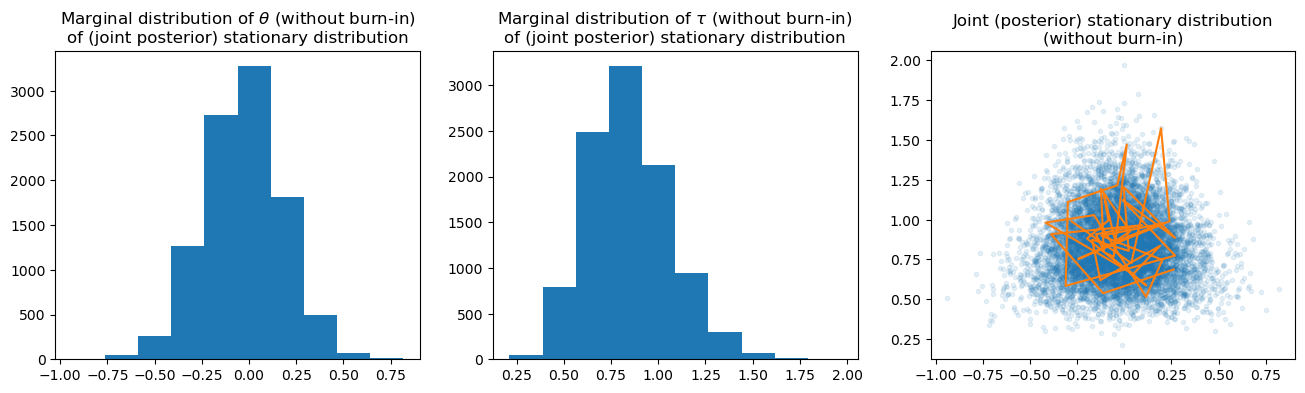

In [14]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

## Metropolis within Gibbs

1. All **full conditional distributions** are proportional to the **joint**.
2. A **Metropolis-Hastings** step can sample from a **full conditional** by proposing a sample and accepting it according to the MH acceptance probability.
3. The target density in the MH acceptance probability appears in the numerator and denomenator so it's normalizing constants cancel and all that's needed 

Accepting draws from a ***proposal distribution*** 

$\tilde \theta^{(t)} \sim q(\tilde \theta^{(t)}|\theta^{(t-1)})$

according to 

$\require{cancel}
\theta^{(t)} = \left\{\begin{array}{ll}
\tilde \theta^{(t)} & \text{with probability } \min\bigg(1,\frac{p(\tilde \theta^{(t)}|\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)}|\tau^{(t)},\mathbf{x})}\overset{\textrm{if symmetric}}{\cancel{\frac{q(\theta^{(t-1)}|\tilde \theta^{(t)})}{q(\tilde \theta^{(t)}|\theta^{(t-1)})}}^1}\bigg) \\
\theta^{(t-1)} & \text{otherwise}\\\\
\end{array}\right.$

will produce draws from $p(\theta^{(t)}|\tau^{(t)},\mathbf{x})$.

If we don't know the **full conditional distributions** *analytically* we can't use the *simple version* of **Gibbs sampling**. *But we do know the full conditional distributions proportionally up to their normalizing constants* and the unknown normalizing constants cancel in the target density ratios

$\frac{p(\tilde \theta^{(t)}|\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)}|\tau^{(t)},\mathbf{x})} = \frac{p(\tilde \theta^{(t)},\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)},\tau^{(t)},\mathbf{x})} = \frac{p(\mathbf{x}|\tilde \theta^{(t)},\tau^{(t)})p(\tilde \theta^{(t)})}{p(\mathbf{x}|\theta^{(t-1)},\tau^{(t)})p(\theta^{(t-1)})}$

so all we need is the **joint distribuiton** (as a function of the parameter of the **full conditional**, here $\theta$).

And an analogous **Metropolis within Gibbs** step exists for $\tau^{(t)}$. 


In [16]:
# # loc is mean and scale is standard deviation
# n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
# C,G = 2,10000  # chains, Gibbs samples
# theta,tau = np.zeros([C,G]),np.zeros([C,G])
# theta[:,0] = 1000  # initialization
# for c in range(C):
#     for g in range(1,G):

#         # the likelihood*prior as a function of tau
#         # is proportional to the full conditional of tau
#         # all of which are proportion to the joint as a function of tau
#         tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c,g-1],
#                                                      scale=1/(tau_)**0.5).pdf(x))*\
#                                   stats.expon(scale=1).pdf(tau_) 
#                                   # arbitrarily chosen tau prior
#         # arbitrarily chosen MH prosal distribution for tau
#         tau_propsal = stats.expon(scale=2)
#         tau_tilde = tau_propsal.rvs()

#         mh_calc = (tau_target(tau_tilde)/tau_target(tau[c,g-1]))*\
#         (tau_propsal.pdf(tau[c,g-1])/tau_propsal.pdf(tau_tilde))
#         acceptance_probability = min(1, mh_calc)
#         if stats.uniform().rvs() < acceptance_probability:
#             tau[c,g] = tau_tilde
#         else:
#             tau[c,g] = tau[c,g-1]
        
#         theta[c,g] = joint * prior_theta


## Homework

---


### **Q1**

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

### **Solution**

GenAI acknowledgement: solved with the help of ChatGPT.

#### 1. Model Setup and Joint Density

Recall that the model is as follows:
- **Likelihood:**  
  For data $x_1,\dots,x_n$ we assume  
  $$
  f(\mathbf{x} \mid \theta, \tau) = \prod_{i=1}^n \sqrt{\frac{\tau}{2\pi}} \exp\!\Bigl(-\frac{\tau}{2}(x_i - \theta)^2\Bigr).
  $$
- **Priors:**  
  For $\theta$ we have a normal prior  
  $$
  p(\theta) \propto \sqrt{\frac{\tau_0}{2\pi}} \exp\!\Bigl(-\frac{\tau_0}{2}(\theta-\theta_0)^2\Bigr),
  $$
  and for $\tau$ a gamma prior  
  $$
  p(\tau) \propto \tau^{\frac{\alpha}{2}-1} \exp\!\Bigl(-\frac{\lambda}{2}\tau\Bigr).
  $$

Thus, the joint posterior density (ignoring constants) is
$$
\pi(\theta, \tau \mid \mathbf{x}) \propto \Biggl[\prod_{i=1}^n \sqrt{\tau} \exp\!\Bigl(-\frac{\tau}{2}(x_i-\theta)^2\Bigr)\Biggr] \exp\!\Bigl(-\frac{\tau_0}{2}(\theta-\theta_0)^2\Bigr) \tau^{\frac{\alpha}{2}-1} \exp\!\Bigl(-\frac{\lambda}{2}\tau\Bigr).
$$

When updating one parameter at a time the factors that do not depend on the parameter being updated cancel in the acceptance ratio.

---

#### 2. Metropolis Update for $\tau$

##### 2.1. Proposal Distribution

Because $\tau$ must be positive, the prompt suggests using a proposal that always gives positive values. A simple and effective choice is to use the prior $p(\tau)$ itself as the proposal distribution. In other words, at each iteration we propose
$$
\tilde{\tau} \sim q(\tau) = p(\tau) \quad \text{(i.e. Gamma with shape } \alpha/2 \text{ and rate } \lambda/2\text{)}.
$$

##### 2.2. Acceptance Ratio

Since the proposal is independent of the current value (an independence sampler) and equals the prior, many factors cancel. In particular, when updating $\tau$ with $\theta$ fixed, the full target density for $\tau$ is
$$
\pi(\tau \mid \theta, \mathbf{x}) \propto f(\mathbf{x}\mid\theta,\tau) \, p(\tau).
$$
In the Metropolis–Hastings acceptance ratio we compute
$$
r = \frac{f(\mathbf{x}\mid \theta, \tilde{\tau})\, p(\tilde{\tau})}{f(\mathbf{x}\mid \theta, \tau^{(t-1)})\, p(\tau^{(t-1)})} \times \frac{q(\tau^{(t-1)})}{q(\tilde{\tau})}.
$$
But since we choose $q(\tau)=p(\tau)$, the factors $p(\tilde{\tau})$ and $q(\tilde{\tau})$ cancel (as do the terms for the current value). Therefore the ratio reduces to
$$
r = \frac{f(\mathbf{x}\mid \theta, \tilde{\tau})}{f(\mathbf{x}\mid \theta, \tau^{(t-1)})}.
$$
Writing out the likelihood (remember that only the parts that depend on $\tau$ matter)
$$
f(\mathbf{x}\mid \theta, \tau) = \tau^{n/2} \exp\!\Bigl(-\frac{\tau}{2}\sum_{i=1}^n (x_i-\theta)^2\Bigr),
$$
the acceptance probability is
$$
\alpha = \min\!\left\{1,\; \frac{\tilde{\tau}^{n/2} \exp\!\Bigl(-\frac{\tilde{\tau}}{2} S\Bigr)}{(\tau^{(t-1)})^{n/2} \exp\!\Bigl(-\frac{\tau^{(t-1)}}{2} S\Bigr)} \right\} = \min\!\left\{1,\; \left(\frac{\tilde{\tau}}{\tau^{(t-1)}}\right)^{n/2} \exp\!\Bigl[-\frac{1}{2}(\tilde{\tau} - \tau^{(t-1)})S\Bigr] \right\},
$$
where
$$
S = \sum_{i=1}^n (x_i-\theta)^2.
$$
Thus, even though we are not using the full conditional for $\tau$, the Metropolis acceptance probability is computed solely from the likelihood.

---

#### 3. Gibbs Update for $\theta$

Since the full conditional for $\theta$ is available (and the prompt does not require a Metropolis update for it), we update $\theta$ exactly as before:
$$
\theta \sim \mathcal{N}\!\Biggl(\frac{n\tau\,\bar{x} + \tau_0\,\theta_0}{n\tau + \tau_0},\; (n\tau+\tau_0)^{-1}\Biggr).
$$
This step remains unchanged.

---

#### 4. Explanation and Comparison

#### How the Metropolis Update Works

- **Proposal:** For $\tau$ we propose a new value $\tilde{\tau}$ drawn from the gamma prior $p(\tau)$. This is convenient because the proposal always yields positive values.
- **Acceptance Ratio:** Because the proposal is identical to the prior, the prior terms cancel with the proposal density in the acceptance ratio. The decision to accept the new $\tilde{\tau}$ depends solely on the likelihood ratio  
  $$
  \left(\frac{\tilde{\tau}}{\tau^{(t-1)}}\right)^{n/2}\exp\!\Bigl(-\frac{1}{2}(\tilde{\tau}-\tau^{(t-1)})S\Bigr).
  $$
- **θ Update:** Once $\tau$ is updated (either accepted or retained), the θ parameter is drawn from its full conditional (as in the original Gibbs sampler).

#### Comparison with the Full Gibbs Sampler

- **Gibbs Sampler (Q2):** The full conditional for $\tau$ is available in closed form (a gamma distribution) and is directly sampled. In that case, each update is exact.
- **Metropolis within Gibbs:** For $\tau$ we avoid the derivation of the full conditional. Instead, we propose a new value and accept/reject it based on the joint density. In our example the acceptance ratio simplifies considerably because the proposal is chosen as the prior.
- **Implications:**  
  - The Metropolis step introduces an accept/reject decision, which can lead to some proposals being rejected (and therefore to autocorrelation in the chain).  
  - If the proposal distribution is chosen well (here, using the prior works nicely as it always gives positive values), then the acceptance probability can be high and the chain will mix well.
  - Using the joint density (likelihood × prior) in the ratio means we do not need to derive the full conditional for $\tau$, which can be advantageous in more complex models.

---

#### 5. Full Algorithm and Code Demonstration

Below is a complete Python code snippet that implements the Metropolis–within–Gibbs sampler for the three sets of hyperparameters (Weak Prior, Strong Prior, and Biased Prior). Comments explain each step.

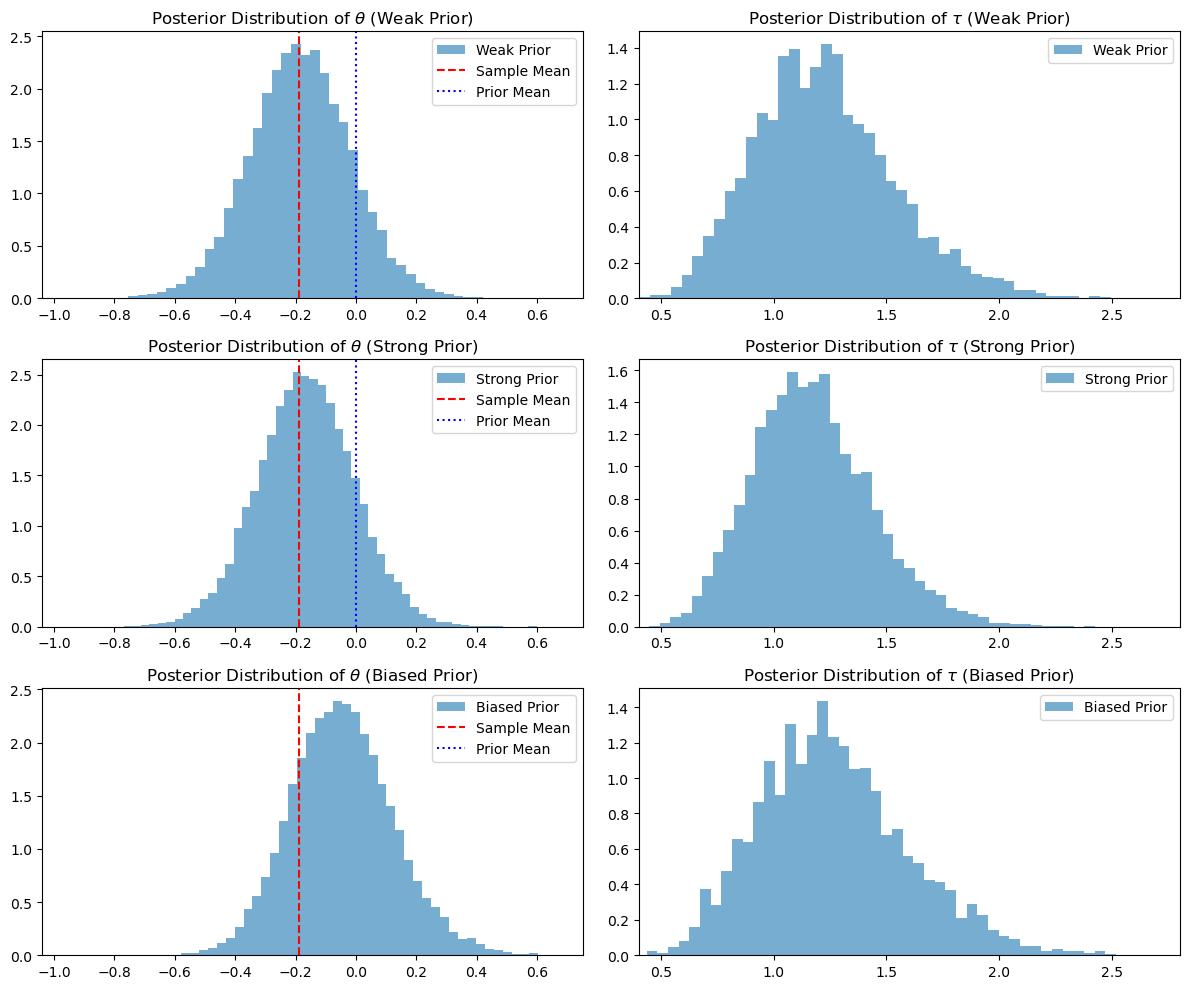

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set seed for reproducibility
np.random.seed(42)

# Data simulation: n observations from N(m, s^2)
n = 30
m, s = 0, 1
x = stats.norm.rvs(loc=m, scale=s, size=n)

# Number of chains and iterations per chain
C, G = 2, 10000

# Prior hyperparameter combinations
prior_combinations = [
    {"alpha": 2, "lambda": 2, "theta_0": 0, "tau_0": 1, "label": "Weak Prior"},
    {"alpha": 10, "lambda": 10, "theta_0": 0, "tau_0": 5, "label": "Strong Prior"},
    {"alpha": 2, "lambda": 0.5, "theta_0": 5, "tau_0": 1, "label": "Biased Prior"}
]

samples_theta, samples_tau = [], []

# Metropolis within Gibbs sampler for each prior combination
for idx, priors in enumerate(prior_combinations):
    alpha, lambda_, theta_0, tau_0 = priors["alpha"], priors["lambda"], priors["theta_0"], priors["tau_0"]
    
    # Pre-allocate storage for the chains
    theta_chain = np.zeros((C, G))
    tau_chain = np.zeros((C, G))
    
    # Initialize theta (and tau)
    theta_chain[:, 0] = 1000   # an arbitrary initial guess for theta
    # For tau, you could use a positive number, e.g. 1
    tau_chain[:, 0] = 1.0

    for c in range(C):
        for g in range(1, G):
            # --- Metropolis step for tau ---
            # Propose new tau from the prior p(tau): Gamma(shape=alpha/2, scale=2/lambda)
            tau_prop = stats.gamma.rvs(a=alpha/2, scale=2/lambda_)
            
            # Compute sum of squared deviations using the current theta
            S = np.sum((x - theta_chain[c, g-1])**2)
            
            # Compute likelihood (up to proportionality) for current and proposed tau
            # f(x|theta, tau) ∝ tau^(n/2) exp( -tau/2 * S )
            current_tau = tau_chain[c, g-1]
            log_like_current = (n/2)*np.log(current_tau) - (current_tau/2)*S
            log_like_prop = (n/2)*np.log(tau_prop) - (tau_prop/2)*S
            
            # Acceptance probability (in log scale)
            log_ratio = log_like_prop - log_like_current
            if np.log(np.random.rand()) < log_ratio:
                tau_chain[c, g] = tau_prop  # accept proposal
            else:
                tau_chain[c, g] = current_tau  # reject proposal, keep previous value

            # --- Gibbs step for theta ---
            # Full conditional: theta ~ N( mean = (n*tau*mean(x) + tau_0*theta_0)/(n*tau + tau_0),
            #                                variance = 1/(n*tau + tau_0) )
            current_tau = tau_chain[c, g]  # use updated tau
            mean_theta = (n * current_tau * np.mean(x) + tau_0 * theta_0) / (n * current_tau + tau_0)
            std_theta = 1 / np.sqrt(n * current_tau + tau_0)
            theta_chain[c, g] = stats.norm.rvs(loc=mean_theta, scale=std_theta)
    
    # Discard burn-in and store samples
    samples_theta.append(theta_chain[:, 20:].flatten())
    samples_tau.append(tau_chain[:, 20:].flatten())

# Plot the posterior samples for theta and tau for each prior combination
theta_min = min(map(np.min, samples_theta))
theta_max = max(map(np.max, samples_theta))
tau_min = min(map(np.min, samples_tau))
tau_max = max(map(np.max, samples_tau))

fig, axes = plt.subplots(len(prior_combinations), 2, figsize=(12, 10))

for idx, priors in enumerate(prior_combinations):
    label = priors["label"]
    
    # Plot posterior samples of theta
    axes[idx, 0].hist(samples_theta[idx], bins=50, density=True, alpha=0.6, label=label)
    axes[idx, 0].axvline(np.mean(x), color="red", linestyle="--", label="Sample Mean")
    axes[idx, 0].axvline(priors["theta_0"], color="blue", linestyle=":", label="Prior Mean")
    axes[idx, 0].set_xlim(theta_min, theta_max)
    axes[idx, 0].set_title(f"Posterior Distribution of $\\theta$ ({label})")
    axes[idx, 0].legend()

    # Plot posterior samples of tau
    axes[idx, 1].hist(samples_tau[idx], bins=50, density=True, alpha=0.6, label=label)
    axes[idx, 1].set_xlim(tau_min, tau_max)
    axes[idx, 1].set_title(f"Posterior Distribution of $\\tau$ ({label})")
    axes[idx, 1].legend()

plt.tight_layout()
plt.show()

### **Q2**

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*

### **Solution**

GenAI acknowledgement: solved with the help of ChatGPT.

#### 1. Model Setup

Suppose we have data  
$$
x_1,\dots,x_n \sim \mathcal{N}(\theta,\, \tau^{-1})
$$
so that the likelihood is
$$
L(\theta,\tau; \mathbf{x}) = \prod_{i=1}^n \sqrt{\frac{\tau}{2\pi}}\exp\!\Bigl(-\frac{\tau}{2}(x_i-\theta)^2\Bigr).
$$

We assume the following priors:

- For $\tau$, we use a Gamma prior (or equivalently an exponential when the Gamma shape is 1):
  $$
  p(\tau) \propto \tau^{\frac{\alpha}{2}-1}\exp\!\Bigl(-\frac{\lambda}{2}\tau\Bigr).
  $$
  (In our demonstration we might set, for example, $\alpha=2$ and $\lambda=2$ so that $\tau$ is exponentially distributed.)

- For $\theta$ we now choose a prior that is not conjugate to the normal likelihood. For instance, we may use a Laplace (double‐exponential) prior:
  $$
  p(\theta) \propto \exp\!\Bigl(-\frac{|\theta-\theta_0|}{b}\Bigr),
  $$
  where $\theta_0$ is a location parameter (say, 0) and $b>0$ is a scale parameter (for example, $b=1$).  
  (Because the Laplace density is not conjugate with the normal likelihood, the full conditional for $\theta$ does not have a standard form.)

Thus the unnormalized joint posterior density is
$$
\pi(\theta,\tau|\mathbf{x}) \propto \tau^{n/2}\exp\!\Bigl(-\frac{\tau}{2}\sum_{i=1}^n (x_i-\theta)^2\Bigr)
\, \tau^{\frac{\alpha}{2}-1}\exp\!\Bigl(-\frac{\lambda}{2}\tau\Bigr)
\, \exp\!\Bigl(-\frac{|\theta-\theta_0|}{b}\Bigr).
$$
Collecting the $\tau$–terms, we have
$$
\pi(\theta,\tau|\mathbf{x}) \propto \tau^{n/2+\frac{\alpha}{2}-1} \exp\!\Bigl(-\frac{\tau}{2}\Bigl[\sum_{i=1}^n (x_i-\theta)^2 + \lambda\Bigr]\Bigr) \exp\!\Bigl(-\frac{|\theta-\theta_0|}{b}\Bigr).
$$

---

#### 2. The Adjusted Sampler

##### 2.1. Dependent Proposal for $\tau$

Rather than drawing $\tau$ independently (e.g. from its prior), we now use a **dependent** proposal based on its previous value. In particular, we use a truncated normal proposal of the form
```python
stats.truncnorm(a=-tau_current/s, b=np.inf, loc=tau_current, scale=s)
```
This means that, given the current value $\tau^{(t-1)}$ (denoted here as `tau_current`), we propose a new value $\tilde{\tau}$ from a truncated normal that is centered at $\tau^{(t-1)}$ with scale parameter $s$ and is truncated to be positive. Because the proposal depends on the current state, we must include the proposal densities in the acceptance ratio.

For the $\tau$ update the acceptance probability is
$$
\alpha_\tau = \min\!\left\{ 1, \frac{\pi(\theta,\tilde{\tau}|\mathbf{x})\,q(\tau^{(t-1)}|\tilde{\tau})}{\pi(\theta,\tau^{(t-1)}|\mathbf{x})\,q(\tilde{\tau}|\tau^{(t-1)})} \right\},
$$
where $q(\cdot\,|\,\cdot)$ is the truncated normal density. When evaluating the proposal density, note that if the proposal from a current value $\tau_c$ is  
$$
q(\tau; \tau_c) = \text{truncnorm.pdf}\Bigl(\tau;\; a=\frac{0-\tau_c}{s},\, b=\infty,\, \text{loc}=\tau_c,\, \text{scale}=s\Bigr),
$$
then the reverse move $q(\tau_c; \tilde{\tau})$ is computed with the same idea but centered at $\tilde{\tau}$.

##### 2.2. Metropolis Update for $\theta$

Because the Laplace prior for $\theta$ does not yield a standard full conditional when combined with the normal likelihood, we update $\theta$ using a Metropolis–Hastings step. A simple choice is a random walk proposal:
$$
\theta^\ast \sim \mathcal{N}(\theta^{(t-1)},\, \sigma_\theta^2),
$$
with acceptance probability
$$
\alpha_\theta = \min\!\left\{ 1,\, \frac{\pi(\theta^\ast,\tau|\mathbf{x})}{\pi(\theta^{(t-1)},\tau|\mathbf{x})} \right\},
$$
since the symmetric proposal density cancels in the ratio.

---

#### 3. Code Demonstration

Below is a full Python example that implements the sampler. In this example we use one chain and a single set of hyperparameters. (The demonstration can be extended to compare different prior settings if desired.)

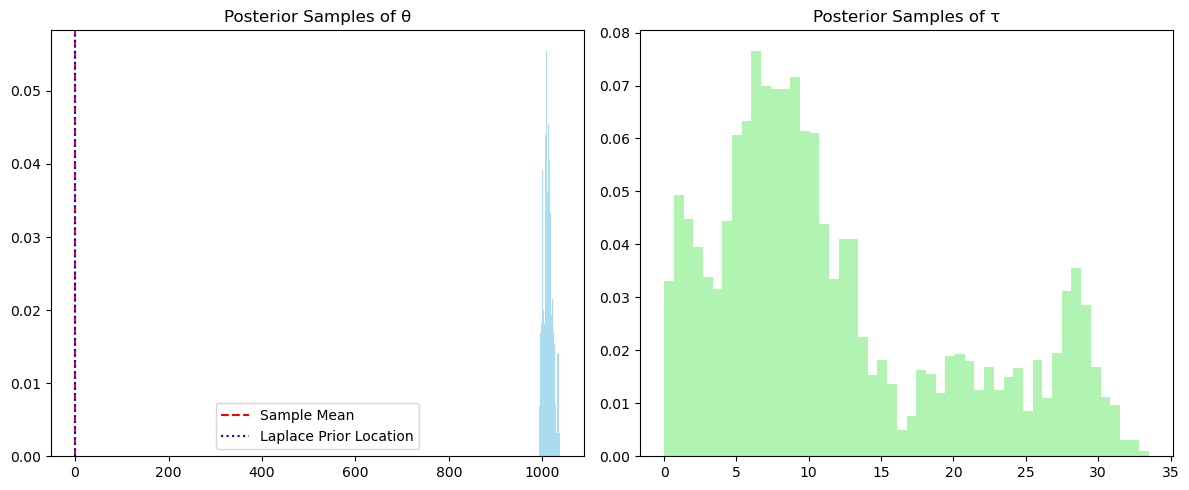

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# -----------------------
# Set up the data
# -----------------------
np.random.seed(42)
n = 30
# Generate data from N(m,s^2)
m, s_true = 0, 1
x = stats.norm.rvs(loc=m, scale=s_true, size=n)

# -----------------------
# Hyperparameters
# -----------------------
# For tau prior: Gamma with shape=alpha/2 and rate=lambda/2
alpha, lambda_ = 2, 2   # for instance, this makes tau ~ Gamma(1, 1) i.e. Exponential(1)
# For theta prior: Laplace with location theta0 and scale b
theta0, b = 0, 1

# Tuning parameters for proposals:
s_tau = 0.5         # scale for the dependent truncated normal proposal for tau
sigma_theta = 0.5   # standard deviation for the random walk proposal for theta

# -----------------------
# Joint density (up to a constant)
# -----------------------
def joint_density(theta, tau, x, alpha, lambda_, theta0, b):
    # tau part: combine likelihood (tau^(n/2) exp(-tau/2 * sum((x-theta)^2)))
    # with tau prior: tau^(alpha/2-1) exp(-lambda*tau/2)
    S = np.sum((x - theta)**2)
    tau_term = (tau**(n/2 + alpha/2 - 1)) * np.exp(-0.5 * tau * (S + lambda_))
    # theta part: Laplace prior density (ignoring constant factors)
    theta_term = np.exp(-np.abs(theta - theta0) / b)
    return tau_term * theta_term

# -----------------------
# Number of iterations and initialization
# -----------------------
G = 5000  # number of iterations
theta_chain = np.zeros(G)
tau_chain = np.zeros(G)

# Initialize: choose positive tau and arbitrary theta
theta_chain[0] = 1000
tau_chain[0] = 1.0

# -----------------------
# Sampler
# -----------------------
for t in range(1, G):
    # ----- Update tau with a dependent (truncated normal) proposal -----
    tau_current = tau_chain[t-1]
    # Define the parameters for the truncated normal:
    # Lower bound is 0, so standardized lower bound is (0 - tau_current)/s_tau.
    a_tau = (0 - tau_current) / s_tau
    b_tau = np.inf
    # Propose new tau from truncnorm
    tau_prop = stats.truncnorm.rvs(a=a_tau, b=b_tau, loc=tau_current, scale=s_tau)
    
    # Evaluate proposal densities:
    # q(tau_prop | tau_current)
    q_forward = stats.truncnorm.pdf(tau_prop, a=a_tau, b=b_tau, loc=tau_current, scale=s_tau)
    # Reverse move: from tau_prop propose tau_current.
    a_rev = (0 - tau_prop) / s_tau
    q_reverse = stats.truncnorm.pdf(tau_current, a=a_rev, b=b_tau, loc=tau_prop, scale=s_tau)
    
    # Compute acceptance ratio for tau:
    # With theta fixed at theta_chain[t-1]
    theta_fixed = theta_chain[t-1]
    num = joint_density(theta_fixed, tau_prop, x, alpha, lambda_, theta0, b) * q_reverse
    den = joint_density(theta_fixed, tau_current, x, alpha, lambda_, theta0, b) * q_forward
    r_tau = num / den if den > 0 else 1
    if np.log(np.random.rand()) < np.log(r_tau):
        tau_chain[t] = tau_prop  # accept
    else:
        tau_chain[t] = tau_current  # reject

    # ----- Update theta with a random walk proposal -----
    theta_current = theta_chain[t-1]
    theta_prop = stats.norm.rvs(loc=theta_current, scale=sigma_theta)
    
    # Compute acceptance ratio for theta update (tau is fixed at the current updated value)
    num_theta = joint_density(theta_prop, tau_chain[t], x, alpha, lambda_, theta0, b)
    den_theta = joint_density(theta_current, tau_chain[t], x, alpha, lambda_, theta0, b)
    r_theta = num_theta / den_theta if den_theta > 0 else 1
    if np.log(np.random.rand()) < np.log(r_theta):
        theta_chain[t] = theta_prop
    else:
        theta_chain[t] = theta_current

# -----------------------
# Plot the results
# -----------------------
burn_in = 500
theta_samples = theta_chain[burn_in:]
tau_samples = tau_chain[burn_in:]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(theta_samples, bins=50, density=True, alpha=0.7, color='skyblue')
axes[0].axvline(np.mean(x), color='red', linestyle='--', label="Sample Mean")
axes[0].axvline(theta0, color='blue', linestyle=':', label="Laplace Prior Location")
axes[0].set_title("Posterior Samples of θ")
axes[0].legend()

axes[1].hist(tau_samples, bins=50, density=True, alpha=0.7, color='lightgreen')
axes[1].set_title("Posterior Samples of τ")
plt.tight_layout()
plt.show()

In [21]:
# Bayesian Inference
# Compute 95% credible intervals for theta and tau
theta_lower, theta_upper = np.percentile(theta_samples, [2.5, 97.5])
tau_lower, tau_upper = np.percentile(tau_samples, [2.5, 97.5])

print("95% Credible Interval for θ:", theta_lower, theta_upper)
print("95% Credible Interval for τ:", tau_lower, tau_upper)

95% Credible Interval for θ: 995.9533015839687 1034.2346275829905
95% Credible Interval for τ: 0.7484867171112737 29.81264411020838


#### 4. Discussion on the Necessity of Deriving Full Conditionals

One of the advantages of the Metropolis–Hastings (MH) algorithm is that it only requires evaluation of the joint density up to a constant of proportionality. Unlike Gibbs sampling, which requires that the full conditional distributions be available in closed form so that one can draw directly from them, MH can be used in situations where the full conditionals are unknown or intractable.

In our example, by switching the prior for \(\theta\) from a normal distribution (which would lead to a conjugate, Gaussian full conditional) to a Laplace distribution, the full conditional for \(\theta\) becomes non-standard. Had we used Gibbs sampling, we would have been forced either to derive and sample from a non-standard distribution or to resort to other approximations. Instead, the MH step for \(\theta\) allows us to bypass an analytical derivation completely—only the ratio of joint densities is required.

Similarly, by adopting a dependent proposal for \(\tau\), we illustrate that even when the proposal distribution is not independent of the current state, one can still use the MH acceptance ratio (with the proper accounting for proposal densities) to ensure that the Markov chain converges to the desired target. In short, when using Metropolis–Hastings within Gibbs, there is no *need* to derive the full conditional distributions analytically as long as one can evaluate the joint density. This flexibility makes MH a powerful tool in Bayesian inference for complex models.

---

This solution demonstrates the adjusted sampler with a dependent proposal for $\tau$ and a Laplace prior for $\theta$ (necessitating an MH update for $\theta$), along with a discussion of why full conditional derivation is not required when using Metropolis–Hastings.

### **Q3** 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example 
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$



This **transition kernel** $K$ means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 


### **Solution**

GenAI acknowledgement: solved with the help of ChatGPT.

#### 1. Derivation of the Transition Kernel

##### a. Proposal Distribution and Cancellation

We are given a proposal for a binary state:
$$
q(\tilde{x}^{(t)} \mid x^{(t-1)}) = \left(\frac{1}{2}\right)^{1-\tilde{x}^{(t)}}\left(\frac{1}{2}\right)^{\tilde{x}^{(t)}}
$$
which implies that for either $ \tilde{x}^{(t)}=0 $ or $ \tilde{x}^{(t)}=1 $,
$$
q(0 \mid x) = \frac{1}{2} \quad \text{and} \quad q(1 \mid x) = \frac{1}{2}.
$$
Because the proposal is independent of the current state $ x $, when computing the Metropolis–Hastings acceptance ratio
$$
\alpha(x, \tilde{x}) = \min\!\left\{1,\, \frac{p(\tilde{x})\,q(x\mid \tilde{x})}{p(x)\,q(\tilde{x}\mid x)}\right\},
$$
the proposal terms cancel:
$$
\frac{q(x\mid \tilde{x})}{q(\tilde{x}\mid x)} = \frac{1/2}{1/2} = 1.
$$
Thus, the acceptance probability reduces to
$$
\alpha(x, \tilde{x}) = \min\!\left\{1,\, \frac{p(\tilde{x})}{p(x)}\right\}.
$$

##### b. Target Distribution

The target distribution is defined as
$$
p(x) = \left(\frac{1}{3}\right)^{1-x}\left(\frac{2}{3}\right)^x,
$$
so that:
- $ p(0)=\frac{1}{3} $
- $ p(1)=\frac{2}{3} $

##### c. Transition Probabilities

Now, we derive the transition probabilities for each current state.

##### **Case 1: Current state $x=0$**

- **Proposal = 0:**  
  - Occurs with probability $q(0|0)=1/2$.  
  - Since $\tilde{x}=0$ equals the current state, the move is accepted automatically.  
  - Thus, $P(0\to0)$ gets a contribution of $1/2$.

- **Proposal = 1:**  
  - Occurs with probability $q(1|0)=1/2$.  
  - Acceptance probability is
    $$
    \alpha(0,1)=\min\Bigl\{1,\, \frac{p(1)}{p(0)}\Bigr\}=\min\Bigl\{1,\, \frac{2/3}{1/3}\Bigr\}=\min\{1,2\}=1.
    $$
  - Thus, the chain moves to $1$ with probability $1/2$.

In summary, when $x=0$:
$$
\Pr(0\to0)=0.5,\quad \Pr(0\to1)=0.5.
$$

##### **Case 2: Current state $x=1$**

- **Proposal = 1:**  
  - Occurs with probability $q(1|1)=1/2$.  
  - Since the proposed state is identical to the current state, the move is accepted (probability 1).  
  - So, $P(1\to1)$ gets a contribution of $1/2$.

- **Proposal = 0:**  
  - Occurs with probability $q(0|1)=1/2$.  
  - Acceptance probability is
    $$
    \alpha(1,0)=\min\Bigl\{1,\, \frac{p(0)}{p(1)}\Bigr\}=\min\Bigl\{1,\, \frac{1/3}{2/3}\Bigr\}=\min\{1,0.5\}=0.5.
    $$
  - Thus, the move from $1\to0$ happens with probability $(1/2)\times(0.5)=0.25$.
  - When the proposal $0$ is rejected (which happens with probability $1-0.5=0.5$), the chain remains in state $1$. This adds another $(1/2)\times(0.5)=0.25$ to $P(1\to1)$.

Hence, when $x=1$:
$$
\Pr(1\to0)=0.25,\quad \Pr(1\to1)=0.5+0.25=0.75.
$$

##### d. Assembling the Transition Kernel

If we define the kernel $K$ so that the columns index the current state and the rows index the next state, we have:
$$
K=\begin{pmatrix}
\Pr(0\to0) & \Pr(1\to0) \\
\Pr(0\to1) & \Pr(1\to1)
\end{pmatrix}
=\begin{pmatrix}
0.5 & 0.25 \\
0.5 & 0.75
\end{pmatrix}.
$$

This shows that if we are currently in state 0 there is a 50% chance to remain in 0 and a 50% chance to move to 1. If we are currently in state 1, there is a 75% chance to remain in 1 and a 25% chance to move to 0. These probabilities then imply geometric run‐lengths in each state; for example, the expected number of consecutive 0’s is $1/(1-0.5)=2$ (i.e. 1 failure before switching) and for 1’s it is $1/(1-0.75)=4$ (i.e. 3 failures before switching). This produces the desired one-to-two (or one-thirds to two-thirds) ratio in the stationary distribution.

---

#### 2. Simulation Demonstration

Below is an annotated Python code snippet that simulates the Markov chain using the derived transition kernel and then plots both the chain evolution and histograms of run lengths.

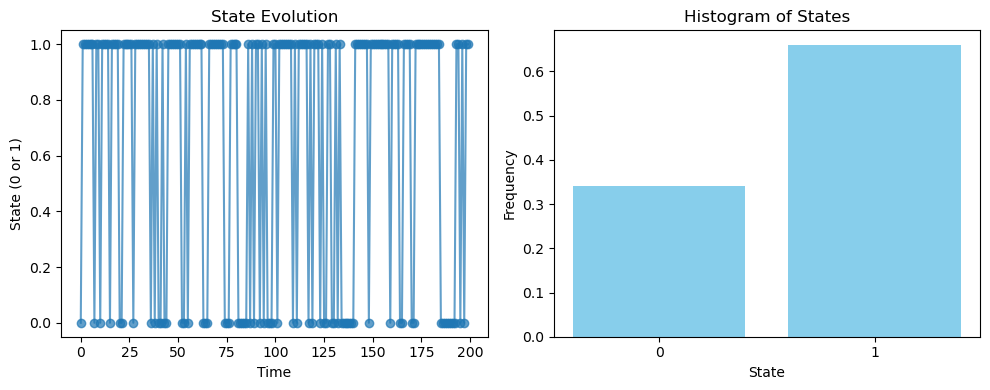

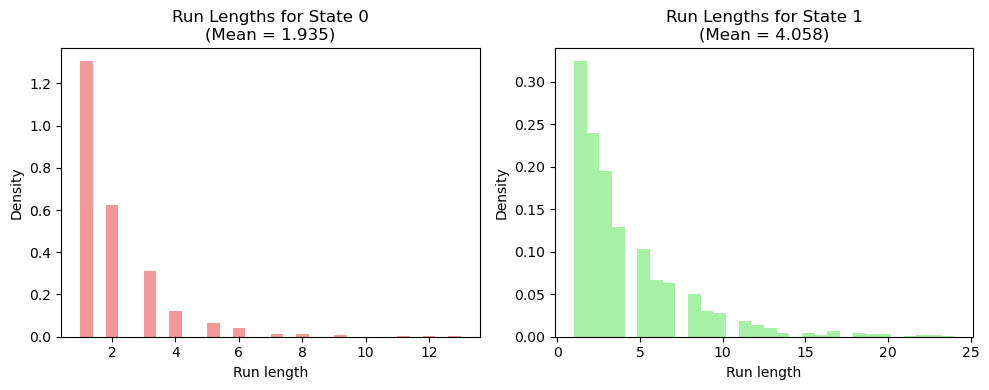

Overall proportion of 1's: 0.6771


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Define the transition kernel matrix K as derived.
# Here, columns correspond to the current state and rows correspond to the next state.
K = np.array([[0.5, 0.25],
              [0.5, 0.75]])

# Function to simulate one step of the Markov chain.
def simulate_next_state(current_state):
    # If current state is 0, probability to transition to 1 is K[1,0]
    # If current state is 1, probability to transition to 1 is K[1,1]
    prob_move_to_1 = K[1, current_state]
    # Generate a uniform random number; if less than prob_move_to_1, move to 1, else 0.
    return int(np.random.rand() < prob_move_to_1)

# First simulation: short chain to illustrate state evolution and histogram.
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = simulate_next_state(s_t[t-1])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(s_t, marker='o', linestyle='-', alpha=0.7)
ax[0].set_title("State Evolution")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("State (0 or 1)")

ax[1].hist(s_t, bins=np.array([-0.5, 0.5, 1.5]), density=True, color='skyblue', rwidth=0.8)
ax[1].set_title("Histogram of States")
ax[1].set_xticks([0, 1])
ax[1].set_xlabel("State")
ax[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Second simulation: longer chain to compute run lengths.
T_long = 10000
s_t = np.zeros(T_long, dtype=int)
for t in range(1, T_long):
    s_t[t] = simulate_next_state(s_t[t-1])
    
state0_run_length = []
state1_run_length = []
run_length = 1

for t in range(1, T_long):
    if s_t[t] == s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length.append(run_length)
        else:
            state1_run_length.append(run_length)
        run_length = 1

# Plot histograms of run lengths for states 0 and 1.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(state0_run_length, bins=30, density=True, color='lightcoral', alpha=0.8)
ax[0].set_title("Run Lengths for State 0\n(Mean = {:.3f})".format(np.mean(state0_run_length)))
ax[0].set_xlabel("Run length")
ax[0].set_ylabel("Density")

ax[1].hist(state1_run_length, bins=30, density=True, color='lightgreen', alpha=0.8)
ax[1].set_title("Run Lengths for State 1\n(Mean = {:.3f})".format(np.mean(state1_run_length)))
ax[1].set_xlabel("Run length")
ax[1].set_ylabel("Density")
plt.tight_layout()
plt.show()

# Print overall state proportions.
print("Overall proportion of 1's:", np.mean(s_t))

#### 3. Final Remarks

This derivation shows explicitly that:
- The proposal probabilities cancel in the acceptance ratio because the proposal is uniform (each candidate has probability 1/2).
- The resulting acceptance probabilities give rise to the transition kernel
  $$
  K=\begin{pmatrix} 0.5 & 0.25 \\ 0.5 & 0.75 \end{pmatrix},
  $$
  which in turn implies that when the chain is in state 0 it is equally likely to stay or move to 1, while in state 1 it is more likely to remain in state 1.  
- These dynamics yield geometric run-length distributions in each state and lead to the desired stationary proportions of $1/3$ for 0 and $2/3$ for 1.

The simulation code verifies both the kernel and the implied run-length behavior.

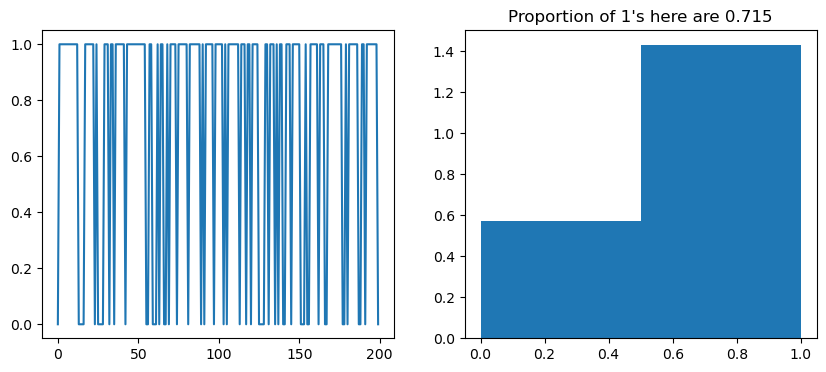

In [25]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

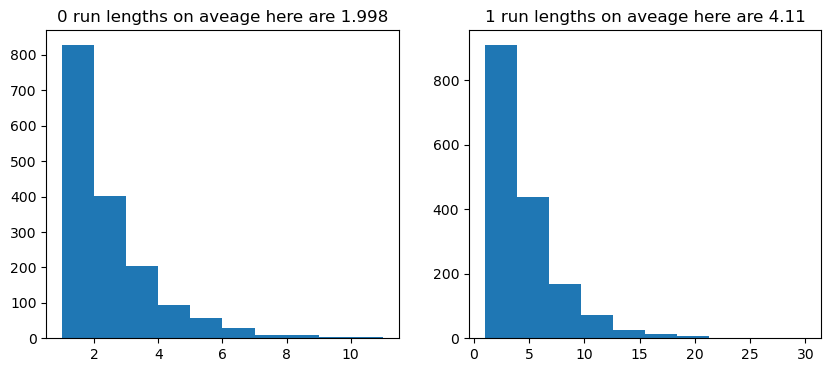

In [26]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));
